![ScreenShot](resources/screenshots/loading_screen.png)

# Project 4 - Advanced Lane Finding Project

### _An Expansion of "Project 1 - Finding Lane Lines"_

#### Please refer to this repository's README.md for a detailed explanation of the project: 
https://github.com/nhiddink/CarND_P4_Advanced_Lane_Finding/blob/master/README.md

### Imports

In [2]:
# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt <---Does not work in Python 3 on Mac

# https://docs.python.org/2/library/pickle.html
import pickle

# https://docs.python.org/2/library/glob.html
import glob

# https://docs.python.org/2/library/os.html
import os

### I. Camera Calibration
#### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('resources/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

### II. Distortion Correction

#### Apply a distortion correction to raw images:

In [ ]:
# Test undistortion on an image
img = cv2.imread('resources/camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('resources/camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("resources/camera_cal/dist_pickle.p", "wb"));

#### Visualize Undistortion using test_dist and test_undist:

In [ ]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10));

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img);
ax1.set_title('Original Image:\n', fontsize=35)
ax2.imshow(dst);
ax2.set_title('Undistorted Image:\n', fontsize=35)

#### Function to unwarp an image:

In [ ]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "resources/camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('resources/camera_cal/calibration2.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img)
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

### III. Color & Gradient Thresholds
#### Use color transforms and gradient operators to create a thresholded binary image.



#### <center> Original Image: </center>
![ScreenShots](resources/test_images/solidYellowLeft.jpg)

In [54]:
img = cv2.imread('resources/test_images/solidYellowLeft.jpg')

#### Visualizing Sobel Operators (x and y directions):

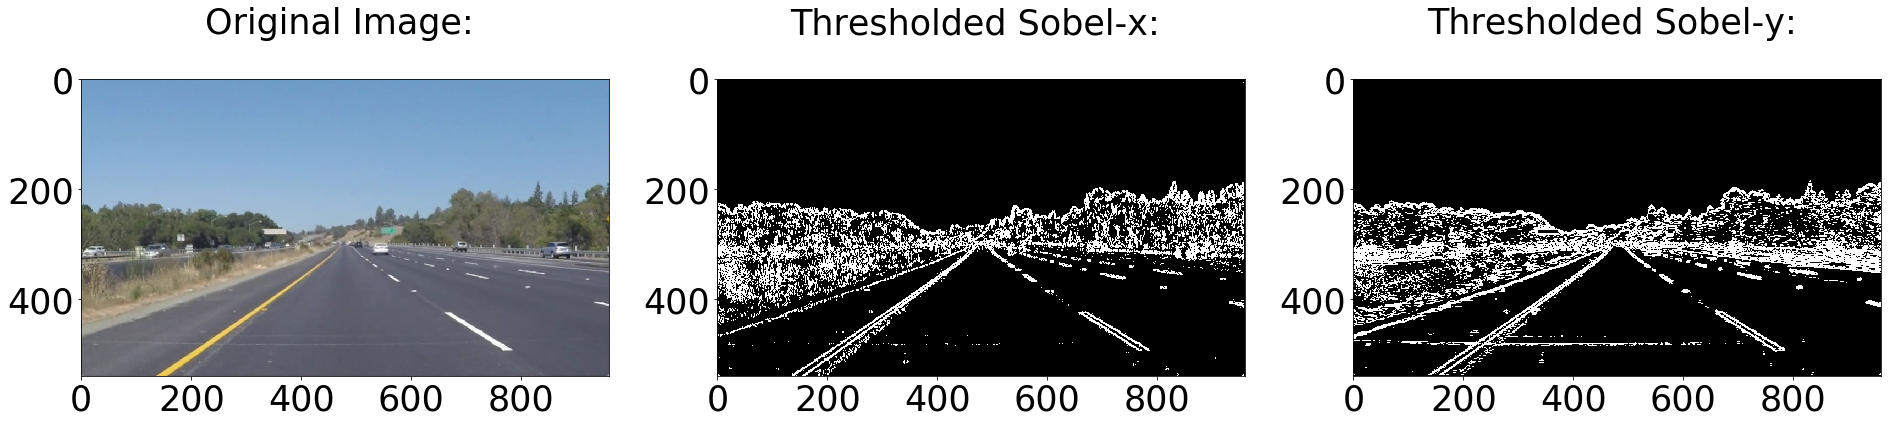

In [55]:
def sobel_operator(img, orient='x', threshold_MIN=0, threshold_MAX=255):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply cv2.Sobel() in x and y
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        #print('Sobel taken in {} direction.'.format(orient))
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        #print('Sobel taken in {} direction.'.format(orient))
    else:
        print('Error: Incorrect orientation of sobel operator.')
    
    # Take the absolute values of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the results to 8-bit ranges (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply lower and upper thresholds
    threshold_MIN = 10
    threshold_MAX = 255
    
    # Create Binary Outputs
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
    
    return binary_output

# Call function and plot visualization
binary_x = sobel_operator(img, orient='x', threshold_MIN=0, threshold_MAX=255)
binary_y = sobel_operator(img, orient='y', threshold_MIN=0, threshold_MAX=255)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(binary_x, cmap='gray')
ax2.set_title('Thresholded Sobel-x: \n', fontsize=35)
ax3.imshow(binary_y, cmap='gray')
ax3.set_title('Thresholded Sobel-y: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing Gradient Magnitude:

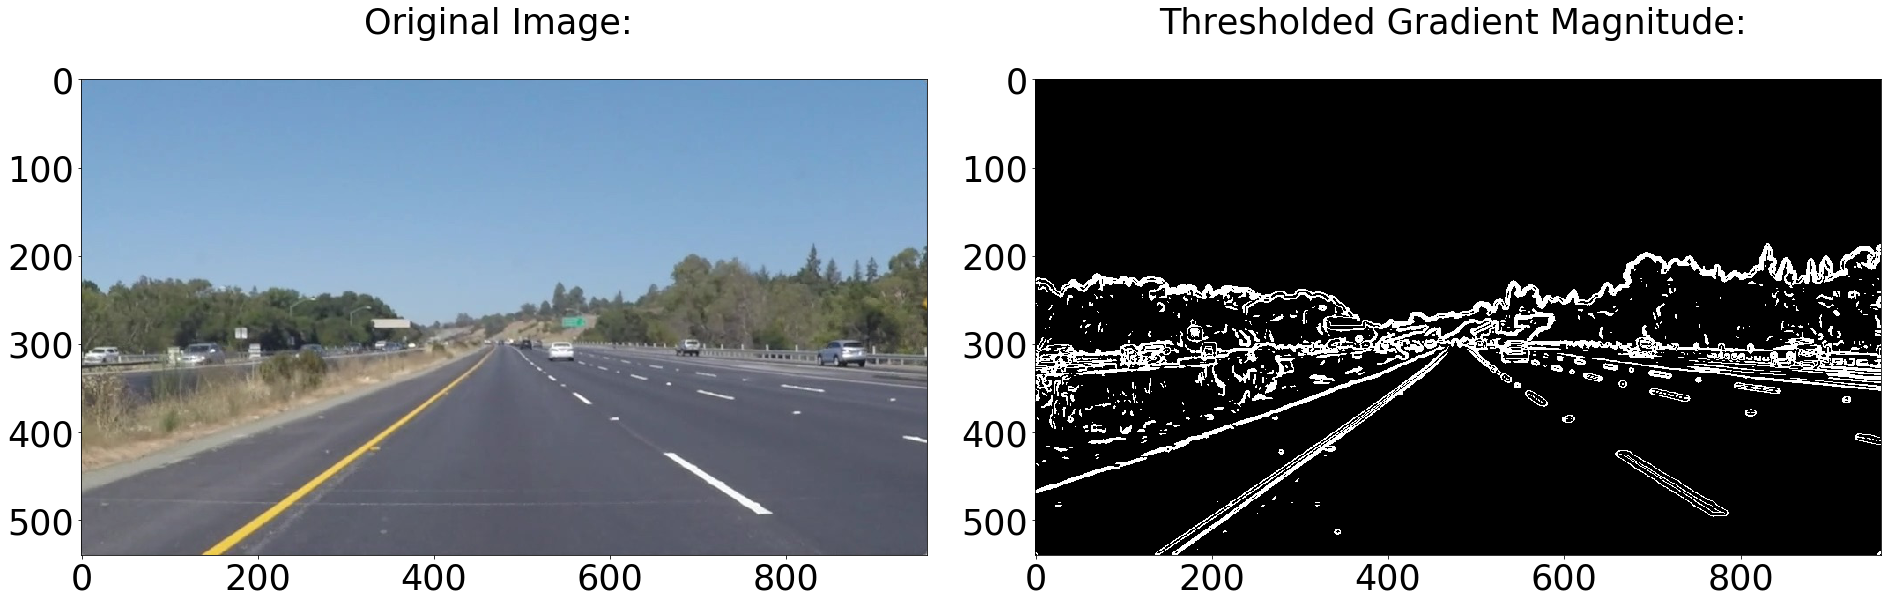

In [56]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def gradient_magnitude(img, sobel_kernel=9, mag_threshold=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & (gradmag <= mag_threshold[1])] = 1

    # Return the binary image
    return binary_output

# Call function and plot visualization
mag = gradient_magnitude(img, sobel_kernel=9, mag_threshold=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(mag, cmap='gray')
ax2.set_title('Thresholded Gradient Magnitude: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing Gradient Direction:

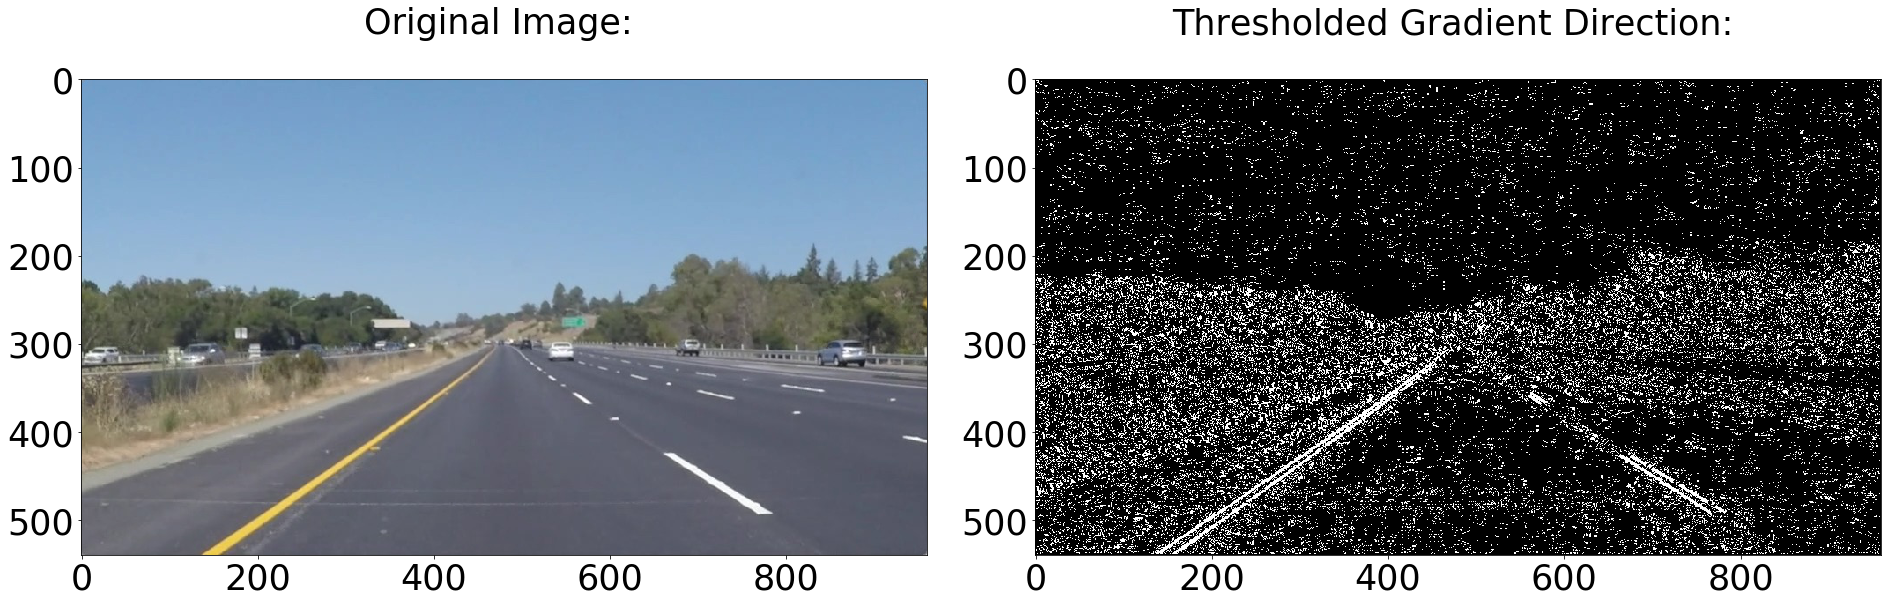

In [57]:
# Define a function that applies Sobel x and y, then computes the direction of the gradient.
def gradient_direction(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients using Sobel()
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value and calculate the direction of the gradient
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))

    # Create a binary mask where the direction thresholds meet 
    binary_output =  np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Call function and plot visualization
direct = gradient_direction(img, sobel_kernel=3, thresh=(0.8, 1.2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(direct, cmap='gray')
ax2.set_title('Thresholded Gradient Direction: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing HLS Color Thresholding (S-Channel):

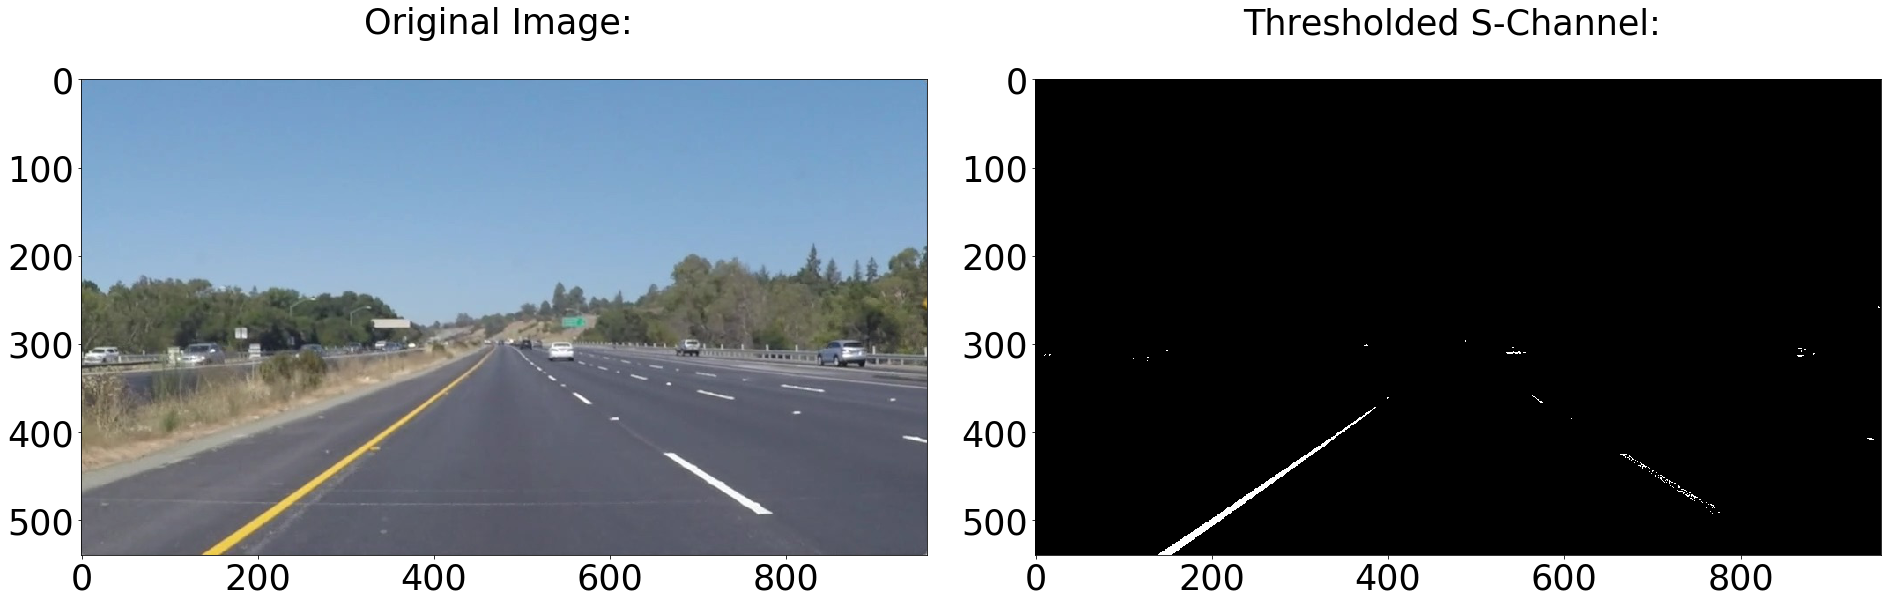

In [63]:
# Define a function that thresholds the S-channel of HLS
def color_threshold(img, threshold=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Apply a threshold to the S-Channel
    s_channel = hls[:,:,2]
    
    # Create and a binary mask of the result
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > threshold[0]) & (s_channel <= threshold[1])] = 1
    
    # Return the result
    return binary_output

# Call function and plot visualization
color = color_threshold(img, threshold=(150, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(color, cmap='gray')
ax2.set_title('Thresholded S-Channel: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Binary Results from Multiple Thresholds:

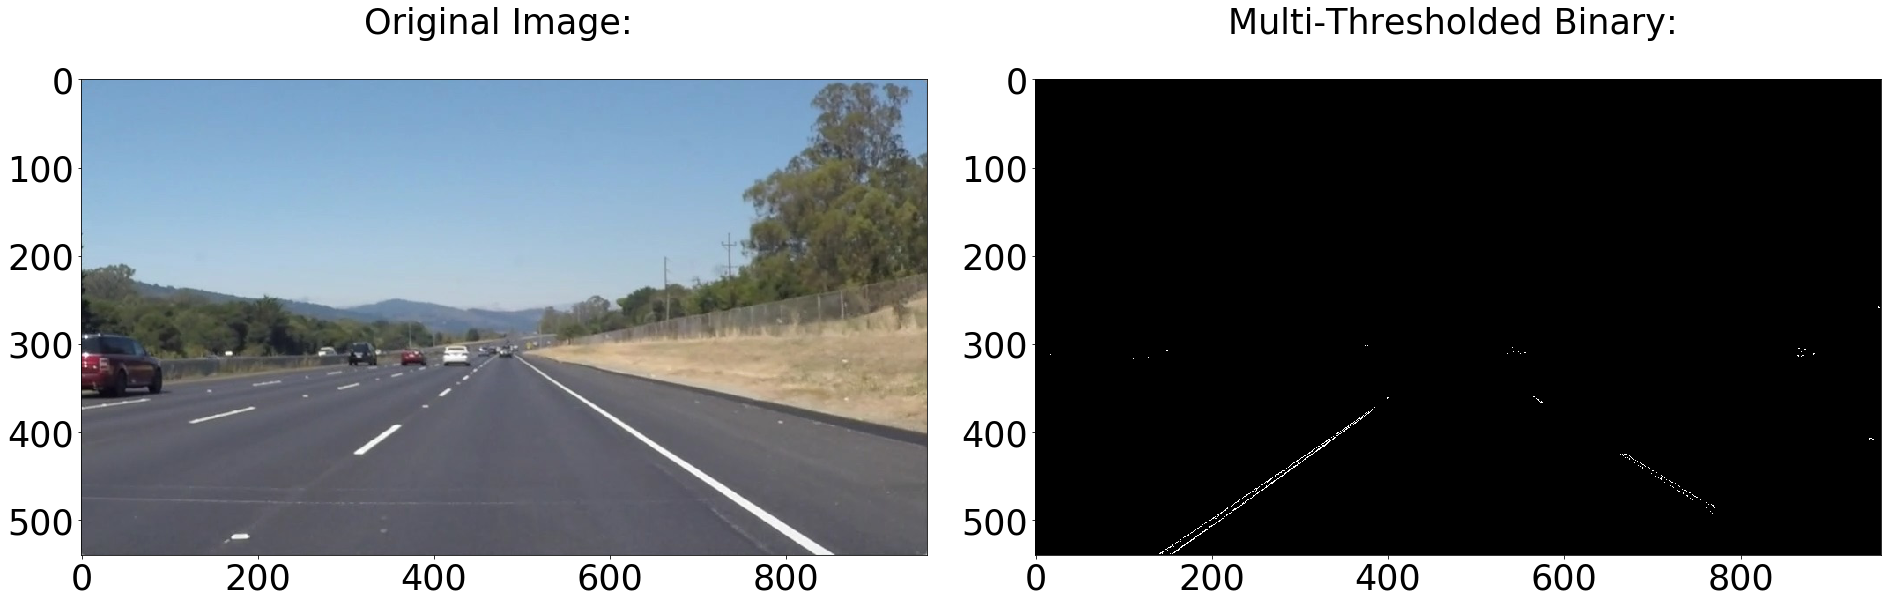

In [64]:
# Combine thresholds and plot visualization
combined_grad = np.zeros_like(direct)
combined_grad[((binary_x == 1) & (binary_y == 1)) | ((mag == 1) & (direct == 1))] = 1

combined = np.zeros_like(combined_grad)
combined[(color == 1) & (combined_grad == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Multi-Thresholded Binary: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

### IV. Perspective Transform
#### Apply a perspective transform to rectify binary image ("birds-eye view").

### V. Detecting Lane Lines
#### Detect lane pixels and fit to find the lane boundary.

### VI. Determining Lane Curvature & Warping to Original Image

#### Determine the curvature of the lane and vehicle position with respect to center.

#### Warp the detected lane boundaries back onto the original image.

### VII. Output
#### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Classes & Helper Methods

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Lane Detection

In [ ]:
#I first take a histogram along all the columns in the lower half of the image like this:

#img = INSERT_thresholded and warped image here!
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [ ]:
#Radius of curvature

import numpy as np
# Generate some fake data to represent lane-line pixels
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              for idx, elem in enumerate(yvals)])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                for idx, elem in enumerate(yvals)])
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(yvals, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, yvals, 'o', color='red')
plt.plot(rightx, yvals, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

In [ ]:
http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC